## Develop approach to examine tracer-percentiles

Following [Sohail et al. (2022)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020GL091439). **NOTE : need to check how to incorporate compressibility, i.e. use of *in situ* density.**

Ocean volume bounded by surfaces of tracer $\phi$:
$$\mathcal{V}(\phi^*,t) = \iiint_{\phi(x,y,z,t)>\phi^*}dxdydz$$
Tracer content/inventory ($\phi$) bounded by surface of tracer $\phi$:
$$\Phi(\phi^*,t) = \int_0^{\mathcal{V}(\phi^*,t)}\rho(x,y,z,t)\,\phi(x,y,z,t)d\mathcal{V}$$
Bounding tracer value of volume $\mathcal{V}$:
$$\mathcal{V}(\phi^*,t)\Leftrightarrow \phi^{\mathcal{V}}(\mathcal{V},t)$$
Tracer-percentile:
$$p(\phi^*,t) = 100*\mathcal{V}(\phi^*,t)/V_T$$
Tracer inventory as a function of tracer-percentile is:
$$\Phi(p,t) = 0.01V_T\int_0^p\rho(p,t)\phi^p(p,t)dp$$
where $\phi^p(p,t) \equiv \phi^{\mathcal{V}}(\mathcal{V},t)$ at $\mathcal{V}=0.01 \times p \times V_T$

In [1]:
import xarray as xr
import cftime
from xhistogram.xarray import histogram
import numpy as np
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import subprocess
import gsw
import oceans.sw_extras.sw_extras as swe

from tracerpercentile import *
from static import *

In [2]:
tracername = 'o2'
dataset = 'cm4' # gobai, esm4, cm4 ...
ascending = False
upper2k = True

### READ

In [3]:
# Check which machine you're on
hostname = subprocess.check_output(['hostname']).decode('utf-8')
if dataset=='gobai':
    if hostname[0:5]!='della':
        raise Error(dataset+" only available on "+hostname)
    else:
        # Dataset particulars
        rootdir = '/projects/SOCCOM/datasets/gobai-o2/'
        filename = 'GOBAI-O2-v1.0_processed_annualmean.zarr'
        # Load data
        ds = xr.open_zarr(rootdir+filename)
        grid = xr.open_dataset(rootdir+'regular_grid.nc')
        ds['volcello']=grid['rC']*grid['dp']
        ds = ds.rename({'temp':'thetao','sal':'so','oxy':'o2','oxysat':'o2sat'})
        
        # process
        # convert umolm-3 to mol m-3
        ds['rhoinsitu'] = gsw.rho(ds['so'],ds['thetao'],ds['pres'])
        conv = ds['rhoinsitu']*1e-6
        ds['o2'] = ds['o2']*conv
        ds['o2sat'] = ds['o2sat']*conv
        
        prefactor = 1
    
elif dataset=='esm4':
    if hostname[0:2]!='an':
        raise Error(dataset+" only available on "+hostname)
    config_id = 'ESM4_historical_D1'
    rootdir = '/work/gam/zarr/'+config_id+'/'
    # tracer
    filename = tracer_args()[tracername]['gfdl_ppname'][dataset]+'.ts.zarr'
    ds = xr.open_zarr(rootdir+filename)
    filename = 'ocean_annual_z_1x1deg.ts.zarr'
    dsvol = xr.open_zarr(rootdir+filename)
    ds['volcello'] = dsvol['volcello']
    
    ds = ds.rename({'z_l':'depth'})
    
    prefactor = 1
    
elif dataset=='cm4':
    if hostname[0:2]!='an':
        raise Error(dataset+" only available on "+hostname)
    config_id = 'CM4_historical'
    rootdir = '/work/gam/zarr/'+config_id+'/'
    # tracer
    filename = tracer_args()[tracername]['gfdl_ppname'][dataset]+'.ts.zarr'
    ds = xr.open_zarr(rootdir+filename)
    filename = 'ocean_annual_z_1x1deg.ts.zarr'
    dsvol = xr.open_zarr(rootdir+filename)
    ds['volcello'] = dsvol['volcello']
    
    ds = ds.rename({'z_l':'depth'})
    
    prefactor = 1

In [4]:
if upper2k:
    ds = ds.sel(depth = slice(0,2000))

In [5]:
tracer = ds[tracername]
volume = ds['volcello']
tracer_bins = tracer_args()[tracername]['bins']

### CALCULATE

In [6]:
percentiles = np.linspace(1,100,100)

ds_tp = calc_tracerpercentile(tracer = tracer,
                              volume = volume,
                              tracer_bins=tracer_bins,
                              percentiles=percentiles,
                              ascending=ascending,
                              extensive=True,
                              prefactor=prefactor,
                              verbose=True)

Computing volumetric histogram.
[########################################] | 100% Completed |  4.7s
Inverting for tracer percentile at each time.
time index : 0/165
time index : 10/165
time index : 20/165
time index : 30/165
time index : 40/165
time index : 50/165
time index : 60/165
time index : 70/165
time index : 80/165
time index : 90/165
time index : 100/165
time index : 110/165
time index : 120/165
time index : 130/165
time index : 140/165
time index : 150/165
time index : 160/165


### SAVE

In [7]:
with ProgressBar():
    ds_tp.to_netcdf(path_tp(tracername,dataset,ascending,upper2k))

[########################################] | 100% Completed |  4.5s


### PLOT

In [20]:
with ProgressBar():
    ds_tp.load()

[########################################] | 100% Completed |  3.8s


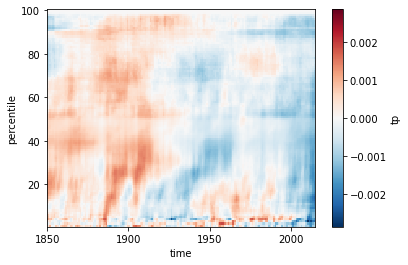

In [21]:
(ds_tp['tp']-ds_tp['tp'].mean('time')).plot()

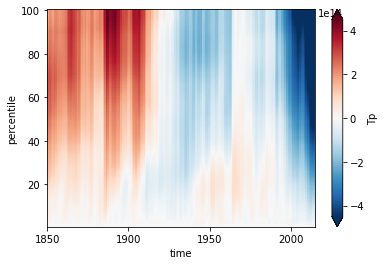

In [22]:
(ds_tp['Tp']-ds_tp['Tp'].mean('time')).plot(robust=True,y='percentile')

In [23]:
t1 = ['2005','2009']
t2 = ['2010','2014']
t1slice = slice(t1[0]+'-01-01',t1[1]+'-12-31')
t2slice = slice(t2[0]+'-01-01',t2[1]+'-12-31')
t1label = t1[0]+' to '+t1[1]
t2label = t2[0]+' to '+t2[1]
t1color='tab:blue'
t2color='tab:orange'
dt = cftime.datetime(int(t2[1]),12,31)-cftime.datetime(int(t1[1]),12,31)
dt = dt.days*24*60*60

In [24]:
tp_t1 = tp.sel(time=t1slice).mean('time')
tp_t2 = tp.sel(time=t2slice).mean('time')
Tp_t1 = Tp.sel(time=t1slice).mean('time')
Tp_t2 = Tp.sel(time=t2slice).mean('time')

NameError: name 'tp' is not defined

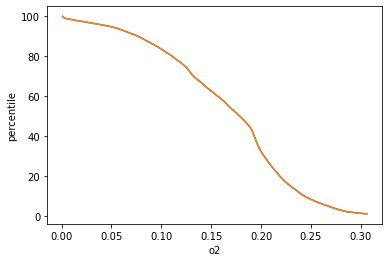

In [10]:
tp_t1.plot(y='percentile')
tp_t2.plot(y='percentile')

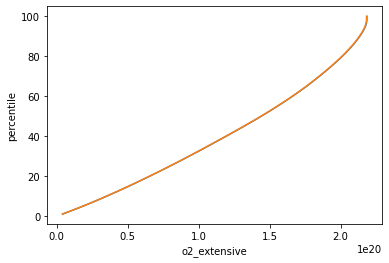

In [11]:
Tp_t1.plot(y='percentile')
Tp_t2.plot(y='percentile')

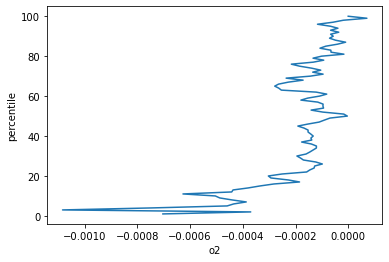

In [12]:
(tp_t2-tp_t1).plot(y='percentile')

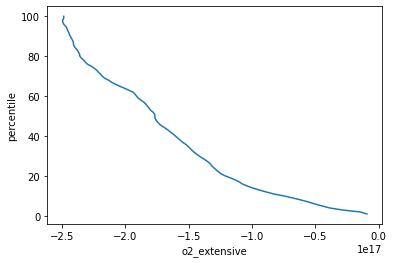

In [13]:
(Tp_t2-Tp_t1).plot(y='percentile')